In [2]:
from IPython.display import display, Javascript, HTML
from datetime import datetime
from utils.notebooks import get_date_slider_from_datetime
from ipywidgets import Layout, interact, Output, widgets, fixed
from ipywidgets.widgets import Dropdown

%store -r the_page
%store -r agg_actions
#%store -r calculator
#%store -r editors_conflicts
%store -r sources

# if ('the_page' not in locals() or 
#     'agg_actions' not in locals() or 
#     'calculator' not in locals() or 
#     'editors_conflicts' not in locals()):
#     import pickle
#     print("Loading default data...")
#     the_page = pickle.load(open("data/the_page.p",'rb'))
#     agg_actions = pickle.load(open("data/agg_actions.p",'rb'))
#     calculator = pickle.load(open("data/calculator.p",'rb'))
#     editors_conflicts = pickle.load(open("data/editors_conflicts.p",'rb'))

display(Javascript('IPython.notebook.execute_cells_below()'))

re_hide = """
<script>
var update_input_visibility = function () {
    Jupyter.notebook.get_cells().forEach(function(cell) {
        if (cell.metadata.hide_input) {
            cell.element.find("div.input").hide();
        }
    })
};
update_input_visibility();
</script>
"""
display(HTML(re_hide))

scroll_to_top = """
<script>
document.getElementById('notebook').scrollIntoView();
</script>
"""

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
%%html
<style>
summary{
    display:list-item;
}

.widget-radio-box{
    flex-direction: row;
}

.widget-radio-box input{
    margin:0 6px 0 5px
}
</style>

In [4]:
%%capture

%load_ext autoreload
%autoreload 2

### <span style="color:green"> Modules Imported </span>

In [5]:
## Modules Imported ##

# Display
from IPython.display import display, Markdown as md, clear_output
from datetime import date
import urllib

# APIs
from wikiwho_wrapper import WikiWho
from external.wikipedia import WikipediaDV, WikipediaAPI
from external.wikimedia import WikiMediaDV, WikiMediaAPI
from external.xtools import XtoolsAPI, XtoolsDV

# Data Processing
import pickle
import pandas as pd

# Visualization tools
import qgrid
import matplotlib.pyplot as plt

# Page views timeline
from visualization.views_listener import ViewsListener

# Change actions timeline
from visualization.actions_listener import ActionsListener

# Conflicts visualization
from visualization.conflicts_listener import ConflictsListener, ConflictsActionListener
from visualization.calculator_listener import ConflictCalculatorListener

# Word cloud visualization
from visualization.wordcloud_listener import WCListener, WCActionsListener
from visualization.wordclouder import WordClouder

# Wikipedia talk pages visualization
from visualization.talks_listener import TalksListener
from visualization.topics_listener import TopicsListener

# Tokens ownership visualization
from visualization.owned_listener import OwnedListener

# To remove stopwords
from visualization.editors_listener import remove_stopwords

# Metrics management
from metrics.conflict import ConflictManager
from metrics.token import TokensManager

# For language selection
from utils.lngselection import abbreviation, lng_listener

# Load the variables stored in the last notebook
%store -r the_page
%store -r total_actions
#%store -r conflict_calculator
#%store -r conflicts_by_editors
%store -r lng_selected

# Check them if in the namespace, otherwise load the default data.
# if ('the_page' not in locals() or 
#     'total_actions' not in locals() or 
#     'conflict_calculator' not in locals() or 
#     'conflicts_by_editors' not in locals()):
    
#     print("Loading default data...")
#     the_page = pickle.load(open("data/the_page.p",'rb'))
#     total_actions = pickle.load(open("data/agg_actions.p",'rb'))
#     conflict_calculator = pickle.load(open("data/calculator.p",'rb'))
#     conflicts_by_editors = pickle.load(open("data/editors_conflicts.p",'rb'))

no stored variable or alias total_actions


# Focus on a selected editor

In this notebooks, we shift the focus to a particular editor. Instead of looking at a particular page an explore activity related to it, we select an editor that contributed to the page that has been analyzed, and explore their activity withing the page.

In [6]:
display(md(f"### ***Page: {the_page['title']} ({lng_selected.upper()})***"))

### ***Page: The Camp of the Saints (EN)***

---

#### Troubleshooting:

- Allow some time for the notebook to run fully before interacting with the interface controls. For articles with a long revision history, this could take minutes and the interaction with the controls will be slow.
- **All cells should run automatically** when you open the notebook. If that is not the case, please just reload the tab in your browser. 
- After chosing a new editor, please rerun the cells/modules you want to use. 
- You should not see any code when you run it for the first time. If so, please let us know by posting an issue in our Github repository: https://github.com/gesiscss/IWAAN.


---

# A. Conflict score

To calculate the conflict score for an editor, we used the same metric of conflict that was used in the previous notebook.

## A.1 Antagonists - Which editors has been in conflict with others?

The table below presents the conflict score and other related metrics per editor idenfied by both, editor_id and editor username:

<br>

<details>    
    <summary style="cursor: pointer;font-weight:bold">Columns description</summary>
    
- **conflicts**: the total number of conflicts
- **elegibles**: the total number of elegible actions performed by the editor
- **conflict**: the sum of conflict scores of all actions divided by the number of elegible actions
</details>

You can interact with the table, and select an editor. Once you click on a row, the graph below will be updated to display the distribution of two different metrics (Y-axis) accross time (X-axis). The metrics displayed in the black and red traces can be selected in the controls of the plot. 

<br>
 
<details>    
    <summary style="cursor: pointer;font-weight:bold">Description of available metrics</summary>
    
- **Conflict Score**: the sum of conflict scores of all actions divided by the number of elegible actions
- **Absolute Conflict Score**: the sum of conflict scores of all actions (without division)
- **Conflict Ratio**: the count of all conflicts divided by the number of elegible actions
- **Number of Conflicts**: the total number of conflicts
- **Total Elegible Actions**: the total number of elegible actions
</details>

In [7]:
# Build editors agg conflicts.
editors_conflicts = agg_actions.groupby(pd.Grouper(
                            key='editor_id')).agg({'conflicts': 'sum', 'elegibles': 'sum', 'conflict': 'sum'}).reset_index()
editors_conflicts["conflict"] = (editors_conflicts["conflict"] / editors_conflicts["elegibles"])
editors_conflicts = editors_conflicts[editors_conflicts["editor_id"] != 0]
editors_conflicts = agg_actions[['editor_id', 'editor']].drop_duplicates().merge(editors_conflicts.dropna(), 
                                                     on='editor_id').set_index('editor_id').dropna()

def display_conflict_score(editor_df):
    global listener
        
    listener = ConflictsListener(editor_df, bargap=0.8)

    metrics = ['Conflict Score', 'Absolute Conflict Score', 
               'Conflict Ratio',  'Number of Conflicts', 
               'Total Elegible Actions']
    #display(md(f'*Total Page conflict score: {calculator.get_page_conflict_score()}*'))
    display(md(f'*Total Page conflict score: {editor_df.conflict.sum() / editor_df.elegibles.sum()}*'))

    # Visualization

    interact(listener.listen,
             #_range = get_date_slider_from_datetime(editor_df['year_month']),
             _range1=widgets.DatePicker(description='Date starts', value=editor_df['rev_time'].iloc[0], layout=Layout(width='25%')),
             _range2=widgets.DatePicker(description='Date ends', value=editor_df['rev_time'].iloc[-1], layout=Layout(width='25%')),
             granularity=Dropdown(options=['Yearly', 'Monthly', 'Daily'], value='Daily'),
             black=Dropdown(options=metrics, value='Conflict Score'),
             red=Dropdown(options= ['None'] + metrics, value='None'))

def select_editor(editor):
    global the_editor
    global editor_inputname

    editor_inputname=editor
    
    wikipedia_dv = WikipediaDV(WikipediaAPI(lng=lng_selected))
    try:
        the_editor = wikipedia_dv.get_editor(int(editor_inputname))
    except:
        the_editor = wikipedia_dv.get_editor(editor_inputname[2:])

    with out:
        %store the_editor
        %store editor_inputname

        clear_output()
        display(md("### Current Selection:"))
        if 'invalid' in the_editor:
            display(f"The editor {editor_inputname} was not found, try a different editor")
        else:
            # display the data that will be passed to the next notebook
            url = f'{wikipedia_dv.api.base}action=query&list=users&ususerids={editor_inputname}&usprop=blockinfo|editcount|registration|gender&format=json'
            print("Editor's metadata can be found in:")
            print(url)
            display(the_editor.to_frame('values'))
            display(md(f"#### Evolution of the Conflict Score of *{the_editor['name']}*"))

            editor_df = agg_actions[agg_actions['editor_id'] == the_editor['userid']].copy()
            #editor_df = calculator.elegible_actions[
                #calculator.elegible_actions['editor'] == editor_inputname].copy()

            display_conflict_score(editor_df)


def on_selection_change(change):

    try:
        select_editor(qg_obj.get_selected_df().iloc[0].name)
    except:
        print('Problem parsing the name. Execute the cell again and try a different editor.')

qgrid.set_grid_option('maxVisibleRows', 5)
qg_obj = qgrid.show_grid(editors_conflicts)
qg_obj.observe(on_selection_change, names=['_selected_rows'])
                       

display(md("### Select one editor (row) to continue:"))
display(md('**Recommendation:** select an editor with *many conflicts* and *mid-high conflict score*'))
display(qg_obj)
out = Output()
display(out)

# select an editor that does not contain 0| at the beginning
for ed in editors_conflicts.index:
    if ed != 0:
        select_editor(ed)
        break

<span style="color: #626262"> Try yourself! This is what will happen when you select an editor: </span>

In [8]:
%%script false --no-raise-error

### IMPORTANT NOTE: COMMENT THE ABOVE LINE TO EXECUTE THE CELL ###

### ----------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU SELECT AN EDITOR  ###
### ----------------------------------------------------------------- ###

## This is the page you used ##
print('The page that is being used:', the_page['title'], f'({lng_selected.upper()})')

## Use the variable from the last notebook: conflicts_by_editors (pd.DataFrame)        ##
## Display the dataframe using interactive grid, you could learn more through the doc: ##
## https://qgrid.readthedocs.io/en/latest/                                             ##
qgrid.set_grid_option('maxVisibleRows', 5) # Set max visible rows for the grid.
qgrid_init = qgrid.show_grid(editors_conflicts)
display(qgrid_init)

## Get the editor info with Wikipedia API (get_editor() method), more details you could check: ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/external/api.py                        ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/external/wikipedia.py                  ##
wikipedia_dv = WikipediaDV(WikipediaAPI(lng=lng_selected))

# This is an example editor index. You could change it manully by typing in a new index from
# the above grid, e.g. 737021
editor_input_id = editors_conflicts.index[1]

# Get the editor's information in the form of pd.DataFrame
editor_info = wikipedia_dv.get_editor(int(editor_input_id))

## Display the basic information of the selected editor ##
editor_url = f'{wikipedia_dv.api.base}action=query&list=users&ususerids={editor_input_id}&usprop=blockinfo|editcount|registration|gender&format=json'
print("Editor's data can be found in:")
print(editor_url)
display(md("### Current Selection:"))
display(editor_info.to_frame('values'))

## Interactive evolution of conflict score of this editor, using ConflictListner, more details see ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/conflicts_listener.py        ##
## Also use the variable from the last notebook: total_actions                                     ##
display(md(f"#### Evolution of the Conflict Score of *{editor_info['name']}*"))

# Dataframe containing the selected editor's info for interactive
editor_df = agg_actions[agg_actions['editor_id'] == the_editor['userid']].copy()
           
# Create a ConflictsListener instance.
conflicts_listener = ConflictsListener(editor_df, bargap = 0.8)

# Set parameters
begin_date = date(2005, 3, 1)
end_date = date(2019, 6, 1)
frequency = 'Daily' # 'Monthly', 'Daily'

# The metrics we need:
# ['Conflict Score', 'Absolute Conflict Score', 'Conflict Ratio', 'Number of Conflicts',
#  'Total Elegible Actions', ('None')]
# Note: only 'red_line' has 'None' option.
black_line = 'Conflict Score'
red_line = 'None'

print('Time range from', begin_date.strftime("%Y-%m-%d"), 'to', end_date.strftime("%Y-%m-%d"))           
           
conflicts_listener.listen(
    _range1=begin_date,
    _range2=end_date,
    granularity = frequency,
    black = black_line,
    red = red_line
)
           
# store the editor_input_id and editor_info for the usage in next notebook
%store editor_input_id
%store editor_info

---

## A.2 Words in conflict - What did this editor disagree about?

In [9]:
display(md(f"***Page: {the_page['title']} ({lng_selected.upper()})***"))

***Page: The Camp of the Saints (EN)***

The WordCloud displays the most common token strings (words) that a particular editor inserted or deleted and that enter into conflict with other editors. The size of the token string in the WordCloud indicates frequency of actions.

<br>

<details>    
    <summary style="cursor: pointer;font-weight:bold">Source description</summary>

-   **Only Conflicts**: use only the actions that are in conflict.
-   **Elegible Actions**: use only the actions that can potentially enter into conflict, i.e. actions 
that have occurred at least twice, e.g. the token x has been inserted twice (which necessarily implies 
it was remove once), the token x has been deleted twice (which necessarily implies it was inserted twice) 
-   **All Actions**: use all tokens regardles conflict
</details>

**Only top 100 most frequent conflicting words displayed.**

### The below token conflicts ocurred in a total of 197 revisions:

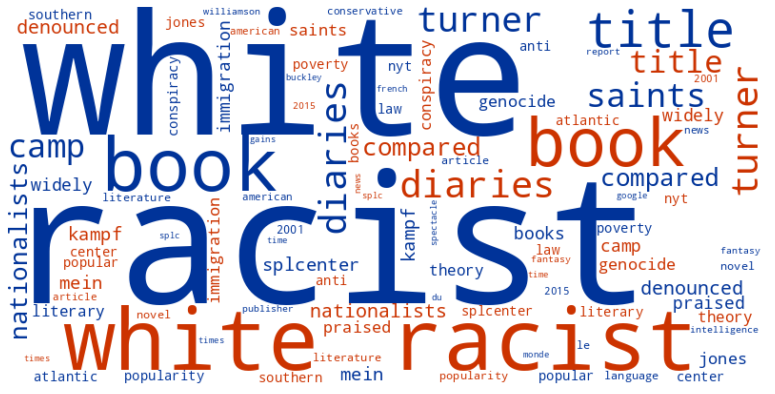

In [10]:
# create and display the button
button2 = widgets.Button(description="Show strings in conflict", layout=Layout(width='180px'))
display(button2)

def on_click_token_conflict(b):
    with out2:
        clear_output()
        display(md(f"***Editor: {the_editor['name']}***"))

        # listener
        listener = WCListener(sources={"tokens_source": sources}, lng=lng_selected, specific_editor=str(editor_inputname))

        # visualization
        actions_all = remove_stopwords(sources["tokens_all"], lng=lng_selected)
        interact(listener.listen, 
                 _range1 = widgets.DatePicker(description='Date starts', value=actions_all.sort_values('rev_time')['rev_time'].iloc[0], layout=Layout(width='25%')),
                 _range2 = widgets.DatePicker(description='Date ends', value=actions_all.sort_values('rev_time')['rev_time'].iloc[-1], layout=Layout(width='25%')),
                 source = Dropdown(options=['All Actions', 'Elegible Actions', 'Only Conflicts'], value='Only Conflicts'),
                 action = Dropdown(options=['Both', 'Just Insertions', 'Just Deletions'], value='Both'),
                 editor = fixed('All'),
                 stopwords = widgets.RadioButtons(options=['Not included', 'Included'], value='Not included', description='Stopwords', layout={'width': '50%'}))

out2 = Output()
display(out2)

# set the event
button2.on_click(on_click_token_conflict)

# trigger the event with the default value
on_click_token_conflict(button2) 

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Show Tokens Into Conflict' button: </span>

In [11]:
%%script false --no-raise-error

### IMPORTANT NOTE: COMMENT THE ABOVE LINE TO EXECUTE THE CELL ###

### ---------------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Tokens Into Conflict' BUTTON ###
### ---------------------------------------------------------------------------------------- ###

## Filter the source data by selected editor, using the instance created in the second notebook     ##
## 'conflict_calculator'. Use three of its attributes: all_actions, elegible_actions and conflicts  ##

## WordCloud, core visual code lies in WCListener, then the interact function               ##
## make it interactive, mode details see:                                                   ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/wordcloud_listener.py ##

editor_info = the_editor
editor_input_id = editor_inputname

# Create a WCListener instance
wclistener = WCListener(sources={"tokens_source": sources}, lng=lng_selected, specific_editor=str(editor_info['userid']))

# Visualization: you could also perform it by coding!
begin_date = date(2005, 3, 1)
end_date = date(2019, 7, 4)
actions_source='Only Conflicts' # 'Elegible Actions', 'All actions', 'Only Conflicts'
action_type='Both' # 'Just Insertions', 'Just Deletions', 'Both'
editor='All'
stopwords = 'Not included'  # 'Not included', 'Included'

wclistener.listen(
     _range1=begin_date,
     _range2=end_date,
     source=actions_source,
     action=action_type,
     editor=editor,
     stopwords=stopwords)

## This is the page you used and the editor you select in the above grid. ##
print('The page that is being used:', the_page['title'], f'({lng_selected.upper()})')
print('Selected editor:', editor_info['name'])
print('Time range from', begin_date.strftime("%Y-%m-%d"), 'to', end_date.strftime("%Y-%m-%d"))

---

# B. Productive activity

## B.1 Activity and productivity - How much work did they do and how much of their work was not undone? 

In [12]:
display(md(f"***Page: {the_page['title']} ({lng_selected.upper()})***"))

***Page: The Camp of the Saints (EN)***

Activity does not mean productivity. The following graphs helps disentangling this two components, for example by comparing the total actions performed with the total actions that survived 48 hours. As previously discussed, actions that are reversed in less than 48 hours are considered noisy, they often correspond to vandalism or low quality editions. The controls allow to select serveral traces to, for example, compare this performance in terms of insertions or deletions as, argueably, insertions could have a higher weight in terms of enriching the content an encyclopedia.

<br>

<details>    
    <summary style="cursor: pointer;font-weight:bold">Options description</summary>
   
- **adds**: number of first-time insertions
- **adds_surv_48h**: number of insertions for the first time that survived at least 48 hours
- **adds_persistent**:  number of insertions for the first time that survived until, at least, the end of the month
- **adds_stopword_count**:  number of insertions that were stop words
- **dels**: number of deletions
- **dels_surv_48h**: number of deletions that were not resinserted in the next 48 hours
- **dels_persistent**: number of deletions that were not resinserted until, at least, the end of the month
- **dels_stopword_count**: number of deletions that were stop words
- **reins**: number of reinsertions
- **reins_surv_48h**: number of reinsertionsthat survived at least 48 hours
- **reins_persistent**: number of reinsertionsthat survived until the end of the month
- **reins_stopword_count**: number of reinsertionsthat were stop words
</details>

In [13]:
# create and display the button
button1 = widgets.Button(description="Show Editor's Activities", layout=Layout(width='180px'))
display(button1)

def on_click_activity(b):
    with out1:
        clear_output()
        display(md(f"***Editor: {the_editor['name']}***"))
        editor_agg_actions = agg_actions[agg_actions['editor_id']==the_editor.userid]

        #Listener
        listener = ActionsListener(sources, lng=lng_selected)
        actions = (editor_agg_actions.loc[:,'total':'total_stopword_count'].columns.append(
            editor_agg_actions.loc[:,'adds':'reins_stopword_count'].columns)).values.tolist()

        # Visualization
        _range = get_date_slider_from_datetime(editor_agg_actions['rev_time'])
        listener.actions_one_editor = editor_agg_actions
        interact(listener.actions_listen, 
                 #_range = get_date_slider_from_datetime(editor_agg_actions['year_month']),
                 _range1=widgets.DatePicker(description='Date starts', value=editor_agg_actions['rev_time'].iloc[0], layout=Layout(width='25%')),
                 _range2=widgets.DatePicker(description='Date ends', value=editor_agg_actions['rev_time'].iloc[-1], layout=Layout(width='25%')),
                 editor=fixed('All'),
                 granularity=Dropdown(options=['Yearly', 'Monthly', "Weekly", "Daily"], value='Monthly'),
                 black=Dropdown(options=actions, value='total'), 
                 red=Dropdown(options= ['None'] + actions, value='total_surv_48h'),
                 green=Dropdown(options= ['None'] + actions, value='None'), 
                 blue=Dropdown(options= ['None'] + actions, value='None'))

out1 = Output()
display(out1)

# set the event
button1.on_click(on_click_activity)

# trigger the event with the default value
on_click_activity(button1)                   

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Show Editor's Activities' button: </span>

In [14]:
%%script false --no-raise-error

### IMPORTANT NOTE: COMMENT THE ABOVE LINE TO EXECUTE THE CELL ###

### ---------------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Tokens Into Conflict' BUTTON ###
### ---------------------------------------------------------------------------------------- ###

editor_info = the_editor
editor_input_id = editor_inputname

editor_agg_actions = agg_actions[agg_actions['editor_id']==the_editor.userid]

# Create an action Listener instance
actions_listener = ActionsListener(sources, lng=lng_selected)

# Visualization: you could also perform it by coding!
begin_date = date(2005, 3, 1)
end_date = date(2019, 7, 4)
editor='All'
frequency = 'Monthly' # "Yearly","Monthly", "Weekly", "Daily"
black_line = 'total'
red_line = 'total_surv_48h'
green_line = 'None'
blue_line = 'None'

# Visualization
actions_listener.actions_one_editor = editor_agg_actions
actions_listener.actions_listen(
    _range1=begin_date,
    _range2=end_date,
    editor=editor,
    granularity=frequency,
    black=black_line, 
    red=red_line,
    green=green_line, 
    blue=blue_line)

## This is the page you used and the editor you select in the above grid. ##
print('The page that is being used:', the_page['title'], f'({lng_selected.upper()})')
print('Selected editor:', editor_info['name'])
print('Time range from', begin_date.strftime("%Y-%m-%d"), 'to', end_date.strftime("%Y-%m-%d"))

---

## B.2 Tokens owned - How much original text from the editor does (still) exist? 

In [15]:
display(md(f"***Page: {the_page['title']} ({lng_selected.upper()})***"))

***Page: The Camp of the Saints (EN)***

Another important metric to asses the impact of an editor is its ownership (or authorship), i.e. who wrote certain word for the first time. The ownership (or authorship) is based in the WikiWho algorithm ([Flöck & Acosta, 2014](http://wwwconference.org/proceedings/www2014/proceedings/p843.pdf)). The time line belows displays the percentage of tokens (Y-axis) owned by an editor at any given point of time (X-axis). 




In [16]:
# create and display the button
button3 = widgets.Button(description="Show Ownership")
display(button3)

def on_click_ownership(b):
    with out3:
        clear_output()
        display(md(f"***Editor: {the_editor['name']}***"))

        all_actions = remove_stopwords(sources["tokens_all"], lng=lng_selected)
        listener = OwnedListener(all_actions, str(editor_inputname))
        traces = ['Tokens Owned', 'Tokens Owned (%)']

        # Visualization
        interact(listener.listen,
                 #_range = get_date_slider_from_datetime(listener.days),
                 _range1=widgets.DatePicker(description='Date starts', value=listener.days.iloc[-1], layout=Layout(width='25%')),
                 _range2=widgets.DatePicker(description='Date ends', value=listener.days.iloc[0], layout=Layout(width='25%')),
                 granularity=Dropdown(options=['Yearly', 'Monthly', "Weekly", 'Daily'], value='Monthly'),
                 trace=Dropdown(options=traces, value='Tokens Owned (%)', description='metric'))

out3 = Output()
display(out3)

# set the event
button3.on_click(on_click_ownership)

# trigger the event with the default value
on_click_ownership(button3)

<span style="color: #626262"> Try yourself! This is what will happen when you click 'Show Ownership' button: </span>

In [17]:
%%script false --no-raise-error

### IMPORTANT NOTE: COMMENT THE ABOVE LINE TO EXECUTE THE CELL ###

### ----------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Show Ownership' BUTTON ###
### ----------------------------------------------------------------------------- ###

editor_info = the_editor
editor_input_id = editor_inputname

## This is the page you used and the editor you select in the above grid. ##
print('The page that is being used:', the_page['title'], f'({lng_selected.upper()})')
print('Selected editor:', editor_info['name'])

## Tokens ownership visualization, core visual code lies in OwnedListener, then the interact function ##
## make it interactive, mode details see:                                                             ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/owned_listener.py               ## 

# Get all actions of all editors in this page, using the 'conflict_calculator' instance, created
# in the second notebook.
all_actions_cal = remove_stopwords(sources["tokens_all"], lng=lng_selected)

# Creat an OwnedListener instance for the selected editor.
ownedlistener = OwnedListener(all_actions_cal, str(editor_inputname))
owned_traces = ['Tokens Owned', 'Tokens Owned (%)']

# Visualization: you could also perform it by coding!
begin_date = date(2005, 9, 18)
end_date = date(2021, 3, 16)
frequency = 'Monthly' # 'Daily', 'Yearly', 'Monthly'
owned_trace = 'Tokens Owned (%)' # 'Tokens Owned', 'Tokens Owned (%)'

print('Time range from', begin_date.strftime("%Y-%m-%d"), 'to', end_date.strftime("%Y-%m-%d"))

ownedlistener.listen(
    _range1=begin_date,
    _range2=end_date,
    granularity=frequency,
    trace=owned_trace
)

In [18]:

scroll_to_top = """
<script>
document.getElementById('notebook').scrollIntoView();
</script>
"""

display(HTML(scroll_to_top))